# Model for Traffic Sign Classifier
## Step 0: Load all modules that are necessary ##

In [12]:
####### Module to retrieve pickled data######
from sklearn.utils import shuffle
from PreProcessing import load_data
########## Plotting Data ########
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from tqdm import trange
import time
from datetime import datetime
import cv2

####### Mathematical & Array Operations #########
import numpy as np
import math
from random import randint
from collections import namedtuple
import itertools
import pandas as pd

# Tensor FLow for Neural Network Frameworks
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import apply_regularization
from tensorflow.contrib.layers import l1_regularizer
from tensorflow.contrib.layers import xavier_initializer
from spatial_transformer import transformer
from sklearn.metrics import confusion_matrix

%matplotlib inline

Modules Imported


ModuleNotFoundError: No module named 'spatial_transformer'

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [4]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

tf.reset_default_graph()
########## Graph Inputs #########################
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int64, (None))
num_classes = 43
reg_fac = tf.placeholder(tf.float32, None)
rate = tf.placeholder(tf.float32, None)
is_training = tf.placeholder(tf.bool, None)

### Basic Elements of the VGG Network
- ** Batch Normalization Layer ** For faster and better training 
- **Param Relu** For solving Dead Linear Rectifier issue during training
- **Convolution Layer** With Parametric Relay Activation - Weights and Biases Initialization - Xavier Scheme
- **Fully Connected Layer** With Fully Connected Dense Layers - Weights and Biases Initialization - Xavier Scheme
- ** Pooling Layer** Max Pool 2D Operation

In [5]:
############################# Batch Normalization Layer ##################
def batch_norm(input_, name, n_out, phase_train):
    with tf.variable_scope(name + 'bn'):
        beta = tf.Variable(tf.constant(
            0.0, shape=[n_out]), name=name + 'beta', trainable=True)
        gamma = tf.Variable(tf.constant(
            1.0, shape=[n_out]), name=name + 'gamma', trainable=True)
        if len(input_.get_shape().as_list()) > 3:
            batch_mean, batch_var = tf.nn.moments(
                input_, [0, 1, 2], name=name + 'moments')
        else:
            batch_mean, batch_var = tf.nn.moments(
                input_, [0, 1], name=name + 'moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (
            ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(
            input_, mean, var, beta, gamma, 1e-3)

    variable_summaries(beta)
    variable_summaries(gamma)
    return normed

############################## Parametric ReLU Activation  Layer #########


def parametric_relu(input_, name):
    alpha = tf.get_variable(name=name + '_alpha', shape=input_.get_shape(
    )[-1], initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3), dtype=tf.float32)
    pos = tf.nn.relu(input_)
    tf.summary.histogram(name, pos)
    neg = alpha * (input_ - abs(input_)) * 0.5
    return pos + neg


# Convolutional Layer with activation and batc
def conv(input_, name, k1, k2, n_o, reg_fac, is_tr, s1=1, s2=1, is_act=True, is_bn=True, padding='SAME'):

    n_i = input_.get_shape()[-1].value
    with tf.variable_scope(name):
        weights = tf.get_variable(name + "weights", [k1, k2, n_i, n_o], tf.float32, xavier_initializer(
        ), regularizer=tf.contrib.layers.l2_regularizer(reg_fac))
        biases = tf.get_variable(name +
                                 "bias", [n_o], tf.float32, tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_, weights, (1, s1, s2, 1), padding=padding)
        bn = batch_norm(conv, name, n_o, is_tr) if is_bn else conv
        activation = parametric_relu(tf.nn.bias_add(
            bn, biases), name + "activation") if is_act else tf.nn.bias_add(bn, biases)
        variable_summaries(weights)
        variable_summaries(biases)
    return activation

# Fully connected Layer with activation and ba


def fc(input_, name, n_o, reg_fac, is_tr, p_fc, is_act=True, is_bn=True):
    n_i = input_.get_shape()[-1].value
    with tf.variable_scope(name):
        weights = tf.get_variable(name + "weights", [n_i, n_o], tf.float32, xavier_initializer(
        ),  regularizer=tf.contrib.layers.l2_regularizer(reg_fac))
        biases = tf.get_variable(
            name + "bias", [n_o], tf.float32, tf.constant_initializer(0.0))
        bn = tf.nn.bias_add(tf.matmul(input_, weights), biases)
        activation = batch_norm(bn, name, n_o, is_tr) if is_bn else bn
        logits = parametric_relu(
            activation, name + "activation") if is_act else activation
        
        variable_summaries(weights)
        variable_summaries(biases)

    return tf.cond(is_tr, lambda: tf.nn.dropout(logits, keep_prob=p_fc), lambda: logits)

############################# Max Pooling Layer with activation ##########


def pool(input_, name, k1, k2, s1=2, s2=2):
    return tf.nn.max_pool(input_, ksize=[1, k1, k2, 1], strides=[1, s1, s2, 1], padding='VALID', name=name)

## Spatial Transformer Layer :
The spatial transformation layer consists of a localization layer and an affine transformation layer

### Localization layer
* 5x5  Convolution Filter 
* 3x3 Convolution Filter 
* 1x1 Convolution Filter 
* 128 Dense Layer 
* 64 Dense Layer 
* 6 for Identity Transform 

### Affine Transformation 

In [6]:
############################# Localization Layer for Spatial Transformer L
def localization_net(input_, name, is_tr, reg_fac):
    # Identity transformation
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    # Weight and Bias containing the identity transformation
    W = tf.get_variable('loc_weights', [64, 6], tf.float32, xavier_initializer(
    ), regularizer=tf.contrib.layers.l2_regularizer(reg_fac))
    b = tf.Variable(initial_value=initial, name='loc_bias')

    ############ Localization Network for the Spatial transformer network ####
    ##################### 7x7x16 Conv -> 2x2 Max pooling ###################
    locnet = conv(input_, name="locnet_conv1", k1=3, k2=3, n_o=16,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool1", k1=2, k2=2)

    ###################### 5x5x32 Conv -> 2x2 Max pooling ###################
    locnet = conv(locnet, name="locnet_conv2", k1=3, k2=3, n_o=32,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool2", k1=2, k2=2)

    ###################### 3x3x64 Conv -> 2x2 Max pooling ####################
    locnet = conv(locnet, name="locnet_conv3", k1=3, k2=3, n_o=64,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool3", k1=2, k2=2)
    
    ###################### 3x3x64 Conv -> 2x2 Max pooling ####################
    locnet = conv(locnet, name="locnet_conv4", k1=3, k2=3, n_o=128,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool4", k1=2, k2=2)

    ####################### Fully Connected Layers ###########################
    locnet_fc0 = flatten(locnet)
    locnet_fc1 = fc(locnet_fc0, name="locnet_fc1", n_o=128,
                    reg_fac=reg_fac, is_tr=is_tr, p_fc=.50)
    locnet_fc2 = fc(locnet_fc1, name="locnet_fc2", n_o=64,
                    reg_fac=reg_fac, is_tr=is_tr, p_fc=.50)
    locnet_op = tf.nn.bias_add(tf.matmul(locnet_fc2, W), b)

    return locnet_op

### VGG Layer
- n Back to Back **Convolutions** of same Kernel Size and Strides and Padding as specified by the user
- 1 **Pooling** Layer.
- 1 **Dropout** Layer

In [7]:
def VGG_Layer(input_, name, conv_size, n_layers, pool_size, n_o, reg_fac, is_tr, p_vgg):

    n_i = input_.get_shape()[-1].value
    c_k1 = conv_size
    c_k2 = conv_size
    p_k1 = pool_size
    p_k2 = pool_size

    vgg = input_
    for i in range(n_layers):
        ############## VGG Building Block ###############################
        ############## 2 - Conv , 1- Pool 1- Dropout 1 - Batch-Norm ###########
        vgg = conv(vgg, name=name + "conv1_" + str(i), k1=c_k1,
                   k2=c_k2, n_o=n_o, reg_fac=reg_fac, is_tr=is_tr)

    vgg = pool(vgg, name=name + "pool1", k1=p_k1, k2=p_k2)
    vgg = tf.cond(is_tr, lambda: tf.nn.dropout(
        vgg, keep_prob=p_vgg), lambda: vgg)
    return vgg

### Model definition
#### Number of Layers:
- *3* **VGG** Layers
    - First VGG Layer extracts 64 Feature Maps
    - Second VGG Layer extracts 128 Feature Maps
    - Third VGG Layer extracts 256 Feature Maps
- *2* **FC** Layers
    - Fully Connected Layers 512 Hidden Units
    - To 43 Units dependent on the number of classes

#### Reason for Choosing Architecture:
- LeNet acrhitecture provides 96.5% test accuracy 
- To get the extra 2% accuracy on the model.

In [8]:
def run_model(input_, num_classes, params, reg_fac, is_training):

    ############## Spatial Transformer Module ######################
    ##################### Localization layer #######################
    locnet = localization_net(input_, name="locnet",
                              reg_fac=reg_fac, is_tr=is_training)
    ####################### Affine Transformation Layer ############
    stn = transformer(input_, locnet, out_size=(32, 32, 3))
    stn_= tf.reshape(stn,(-1,32,32,3))
    ################################## VGG Net ###############################
    ################################# VGG- Layer - 1 #########################
    vgg1 = VGG_Layer(stn_, "vgg1", conv_size=3, n_layers=2, pool_size=2, n_o=32,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg1)
    variable_summaries(vgg1)
    ################################# VGG- Layer - 2 #########################
    vgg2 = VGG_Layer(vgg1, "vgg2", conv_size=3,  n_layers=2, pool_size=2, n_o=64,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg2)
    variable_summaries(vgg2)
    ################################# VGG- Layer - 3 #########################
    vgg3 = VGG_Layer(vgg2, "vgg3", conv_size=3,  n_layers=3, pool_size=2, n_o=128,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg3)
    variable_summaries(vgg3)
    ################################# VGG- Layer - 4 #########################
    vgg4 = VGG_Layer(vgg3, "vgg4", conv_size=3,  n_layers=3, pool_size=2, n_o=256,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg4)
    variable_summaries(vgg4)
    ################################ Multi Scale Convolution layer ###########
    ms1 = pool(vgg2, "ms1", k1=2, k2=2)
    ms2 = tf.concat([ms1,vgg3], axis=3)
    
    ms3 = pool(ms2, "ms3", k1=2, k2=2)
    ms = tf.concat([ms3, vgg4], axis=3)

    
    ################## Fully Connected Layers for a Linear Classifier ########
    #############################First Fully Connected Layer #################
    fc0 = fc(flatten(ms), "fc0", 1024, reg_fac=reg_fac,
             is_tr=is_training, p_fc=params.fc0)
    fc1 = fc(fc0, "fc1", 512, reg_fac=reg_fac,
             is_tr=is_training, p_fc=params.fc1)
    ########################### Output readout Layer #########################
    fc2 = fc(fc1, "fc2", num_classes, reg_fac=reg_fac,
             is_tr=is_training, p_fc=1.0, is_act=False, is_bn=True)

    return fc2

### Model Building with Hyper_params

In [9]:
params = namedtuple('params', 'vgg1 vgg2 vgg3 vgg4 ms fc0 fc1')
mdltype = params(vgg1=.5, vgg2=.5, vgg3=.5, vgg4=.5, ms=.5, fc0=.5, fc1=.5)
logits = run_model(x, num_classes, mdltype, reg_fac, is_training)
tf.summary.histogram('Logits', logits)

# For Top 5 Guesses
prediction = tf.nn.softmax(logits)
top5_guesses = tf.nn.top_k(prediction, k=5, sorted=True)


# Predicted Label and Actual Label using Argmax
y_pred = tf.argmax(logits, 1)

# Accuracy Calculation
correct_prediction = tf.equal(y_pred, y)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('Accuracy', accuracy_operation)

######### Cross Entropy and Loss for Training ##########
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=y, name='cross_entropy')
loss_operation = tf.reduce_mean(
    cross_entropy) + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
tf.summary.scalar('Loss', loss_operation)

########### Training Step ################
Train_Step = tf.train.AdamOptimizer(rate).minimize(loss_operation)
summary = tf.summary.merge_all()

In [10]:
def evaluate(X_data, y_data, batch_size, is_tr):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        bx, by = X_data[offset:offset +
                        batch_size], y_data[offset:offset + batch_size]
        inputs_ = {x: bx, y: by, is_training: is_tr}
        accuracy = sess.run(accuracy_operation, feed_dict=inputs_)
        total_accuracy += (accuracy * len(bx))
    return total_accuracy / num_examples

def plot_confusion_matrix(X_data,y_data, batch_size, is_tr, normalize=True):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    offset=randint(0,num_examples-batch_size)
    bx, by = X_data[offset:offset +
                    batch_size], y_data[offset:offset + batch_size]
    inputs_ = {x: bx, y: by, is_training: is_tr}
    cm_input = sess.run(y_pred,feed_dict=inputs_)
    cm = confusion_matrix(y_true = by,y_pred = cm_input)
    if normalize is True:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
    
    plt.figure(figsize=(25,25))  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(num_classes)
    
    df=pd.read_csv("signnames.csv")
    plt.xticks(range(num_classes), df['SignName'])
    plt.yticks(range(num_classes), df['SignName'])
    plt.xticks(rotation=90)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('Predicted', fontsize = 24)
    plt.ylabel('True', fontsize= 24)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

### Model Hyper Parameter Definition
- The Hyper Parameters are chosen based on search over 5 epochs
#### Tuning Methodology
- Xavier Initialization
- **Early Stopping** - Restore Chkpt if the accuracy gains in validation don't meet requirements
- **Hyper Parameter** Search over 5 Epcochs for Initial Tuning Hyper Params for best choice of hyper params 
    - Batch Sizes-100,200,300,500
    - Learning rates- 1e-3,5e-4,4e-4,1e-4
    - Regularization factor 1e-5,1e-4, 5e-4
- **Learning rate annealing**,  **Batch size increment**, **Increase dropout rate**
- **Optimizer** - Adam Optimizer as suggested by https://arxiv.org/abs/1412.6980 and http://sebastianruder.com/optimizing-gradient-descent/index.html#adam

In [11]:
training_file = 'train_processed'
validation_file = 'valid_processed'
testing_file = 'test_processed'
X_train,y_train = load_data(training_file)
X_valid,y_valid = load_data(validation_file)
X_test,y_test = load_data(testing_file)

Data and Modules loaded
Data and Modules loaded
Data and Modules loaded


In [12]:
BATCH_SIZE = 500
EPOCHS = 50
REG_FACTOR = 2e-5
RATE = 1e-4
save_file = "VGGNet_29042017"
restore_file ="VGGNet_29042017"
chkpt = './' + save_file
chkpt_restore = './' + restore_file
logdir = chkpt + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
is_restore= True

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.Session()
with sess.as_default():
    sess.run(init)
    ##################  Start Model Training  #######################
    if is_restore:
        saver.restore(sess,chkpt_restore)
    summary_writer = tf.summary.FileWriter(logdir, sess.graph)
    print("Training...")
    print()
    val_acc = []
    for i in range(EPOCHS):
        
        ############ Training Operation ################
        Training_loss = 0
        X_train, y_train = shuffle(X_train, y_train)
        for offset in trange(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            inputs = {x: batch_x, y: batch_y, reg_fac: REG_FACTOR,
                      rate: RATE, is_training: True}
            loss, _ = sess.run([loss_operation, Train_Step], feed_dict=inputs)
            Training_loss += (loss * len(batch_x))

        ################ Evaluation operation ####################
        Validation_Accuracy = evaluate(X_valid, y_valid, 1000, is_tr=False)
        val_acc.append(Validation_Accuracy)
        Training_loss /= len(X_train)
        print("Epochs:", i + 1)
        print("Training_Loss:", Training_loss)
        print("Validation_Accuracy:", Validation_Accuracy)
        
        
        ##### Save Model if the Validation accuracy gets better
        if (max(val_acc) == Validation_Accuracy):
            saver.save(sess, chkpt)
            print("Intermediate Model Save")
            summary_str = sess.run(summary, feed_dict=inputs)
            summary_writer.add_summary(summary_str, i)
            
print("Model saved")

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

###  Confusion Matrix to understand Confusion between classes 

Plot a confusion matrix on a random batch of size to understand confusion between classes in the model

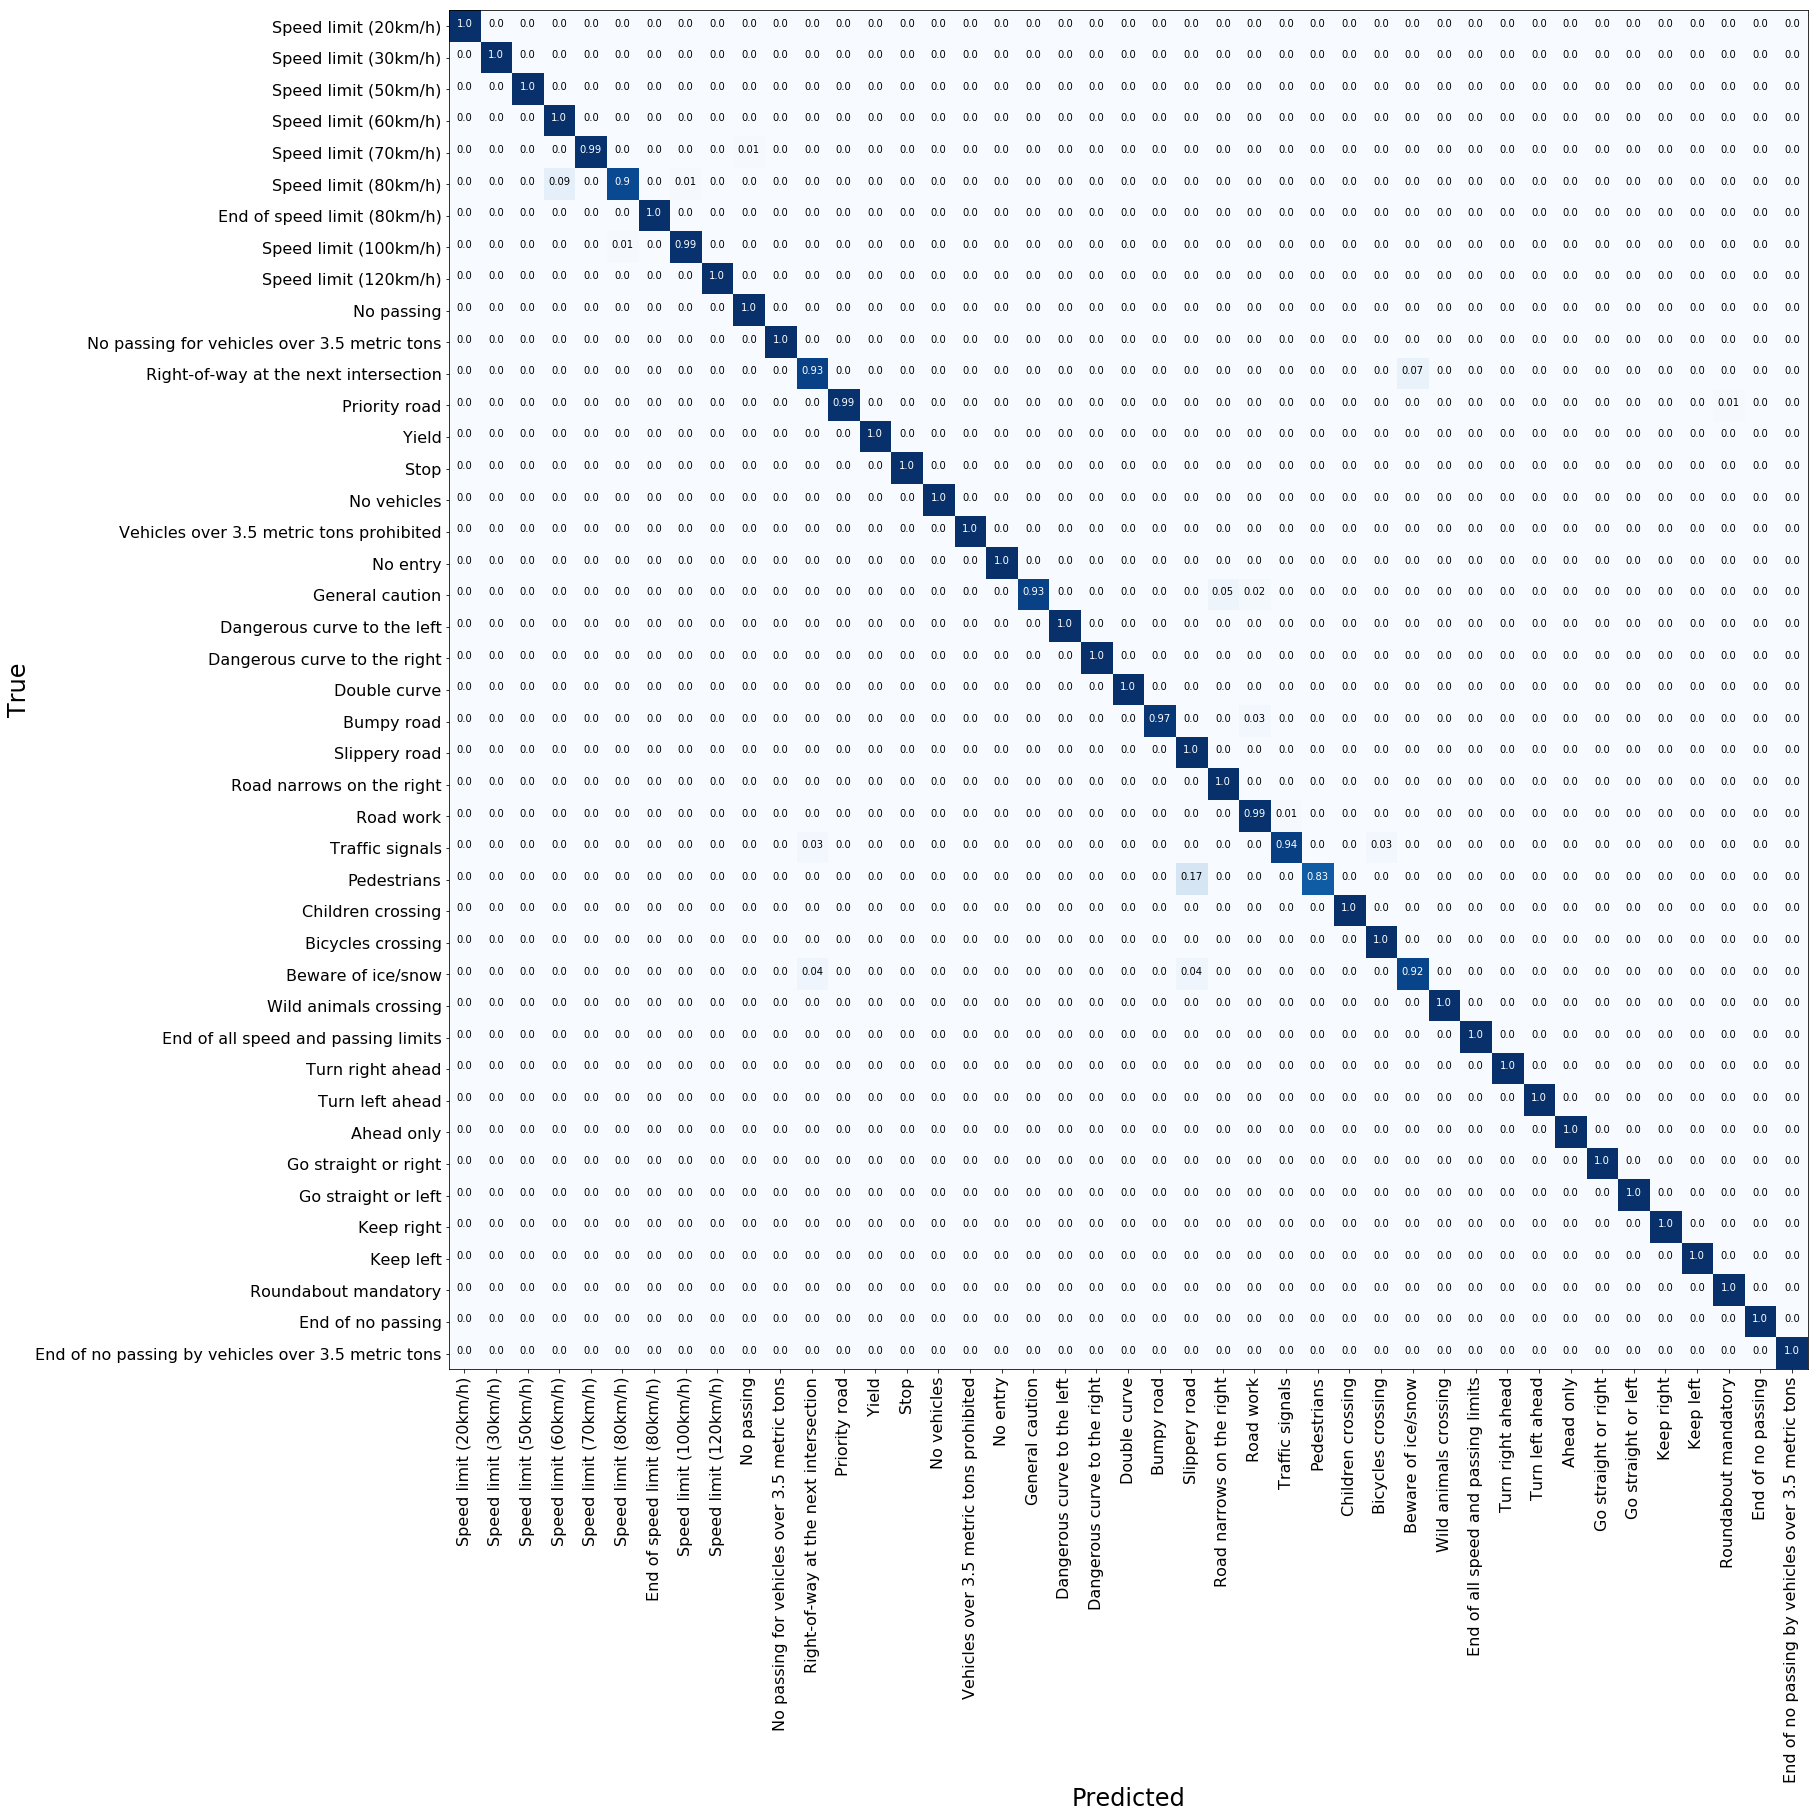

Test Accuracy = 0.987


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
saver=tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,chkpt)
    test_accuracy = evaluate(X_test, y_test, 500, False)
    plot_confusion_matrix(X_test, y_test, 2000, False)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

- The **confusion matrix** helps us understand the confusion between signs as far as classification is concerned. 
- The confusion matrix is **sparse** when 
    - The classifier **differentiates** between features of each class 
    - The slope of the line is **1** - only elements along the diagonal get populated if the predictions match with the actual

> **98.7** Accuracy over Test Set 

### Some Observations in the test results 
- The over all test accuracy is 98.6 % hence the number of incorrect images are 176 out of 12630.
- To dig deeper into where the predictions went wrong and why we get into the confusion matrix.
- In the confusion matrix we see that the Class **Slippery Road** causes confusion to the classifier. 
- It predicts ** Beware of Snow/Ice** ( 89% ) in a random sample of 2000  and ** Pedestrians** (92%) in a random sample of 2000 as slippery road. 
- To understand the sample Distribution we plot the un-normalized random distribution

### Un-normalized confusion matrix
- The random unnormalized confusion matrix provides details into the accuracy of prediction and the class imbalance. 
- The ones that the classifier got wrong are ** Beware of Snow/Ice** ( 89% ) in a random sample of 2000  and ** Pedestrians** (92%). When we look into the number of samples 

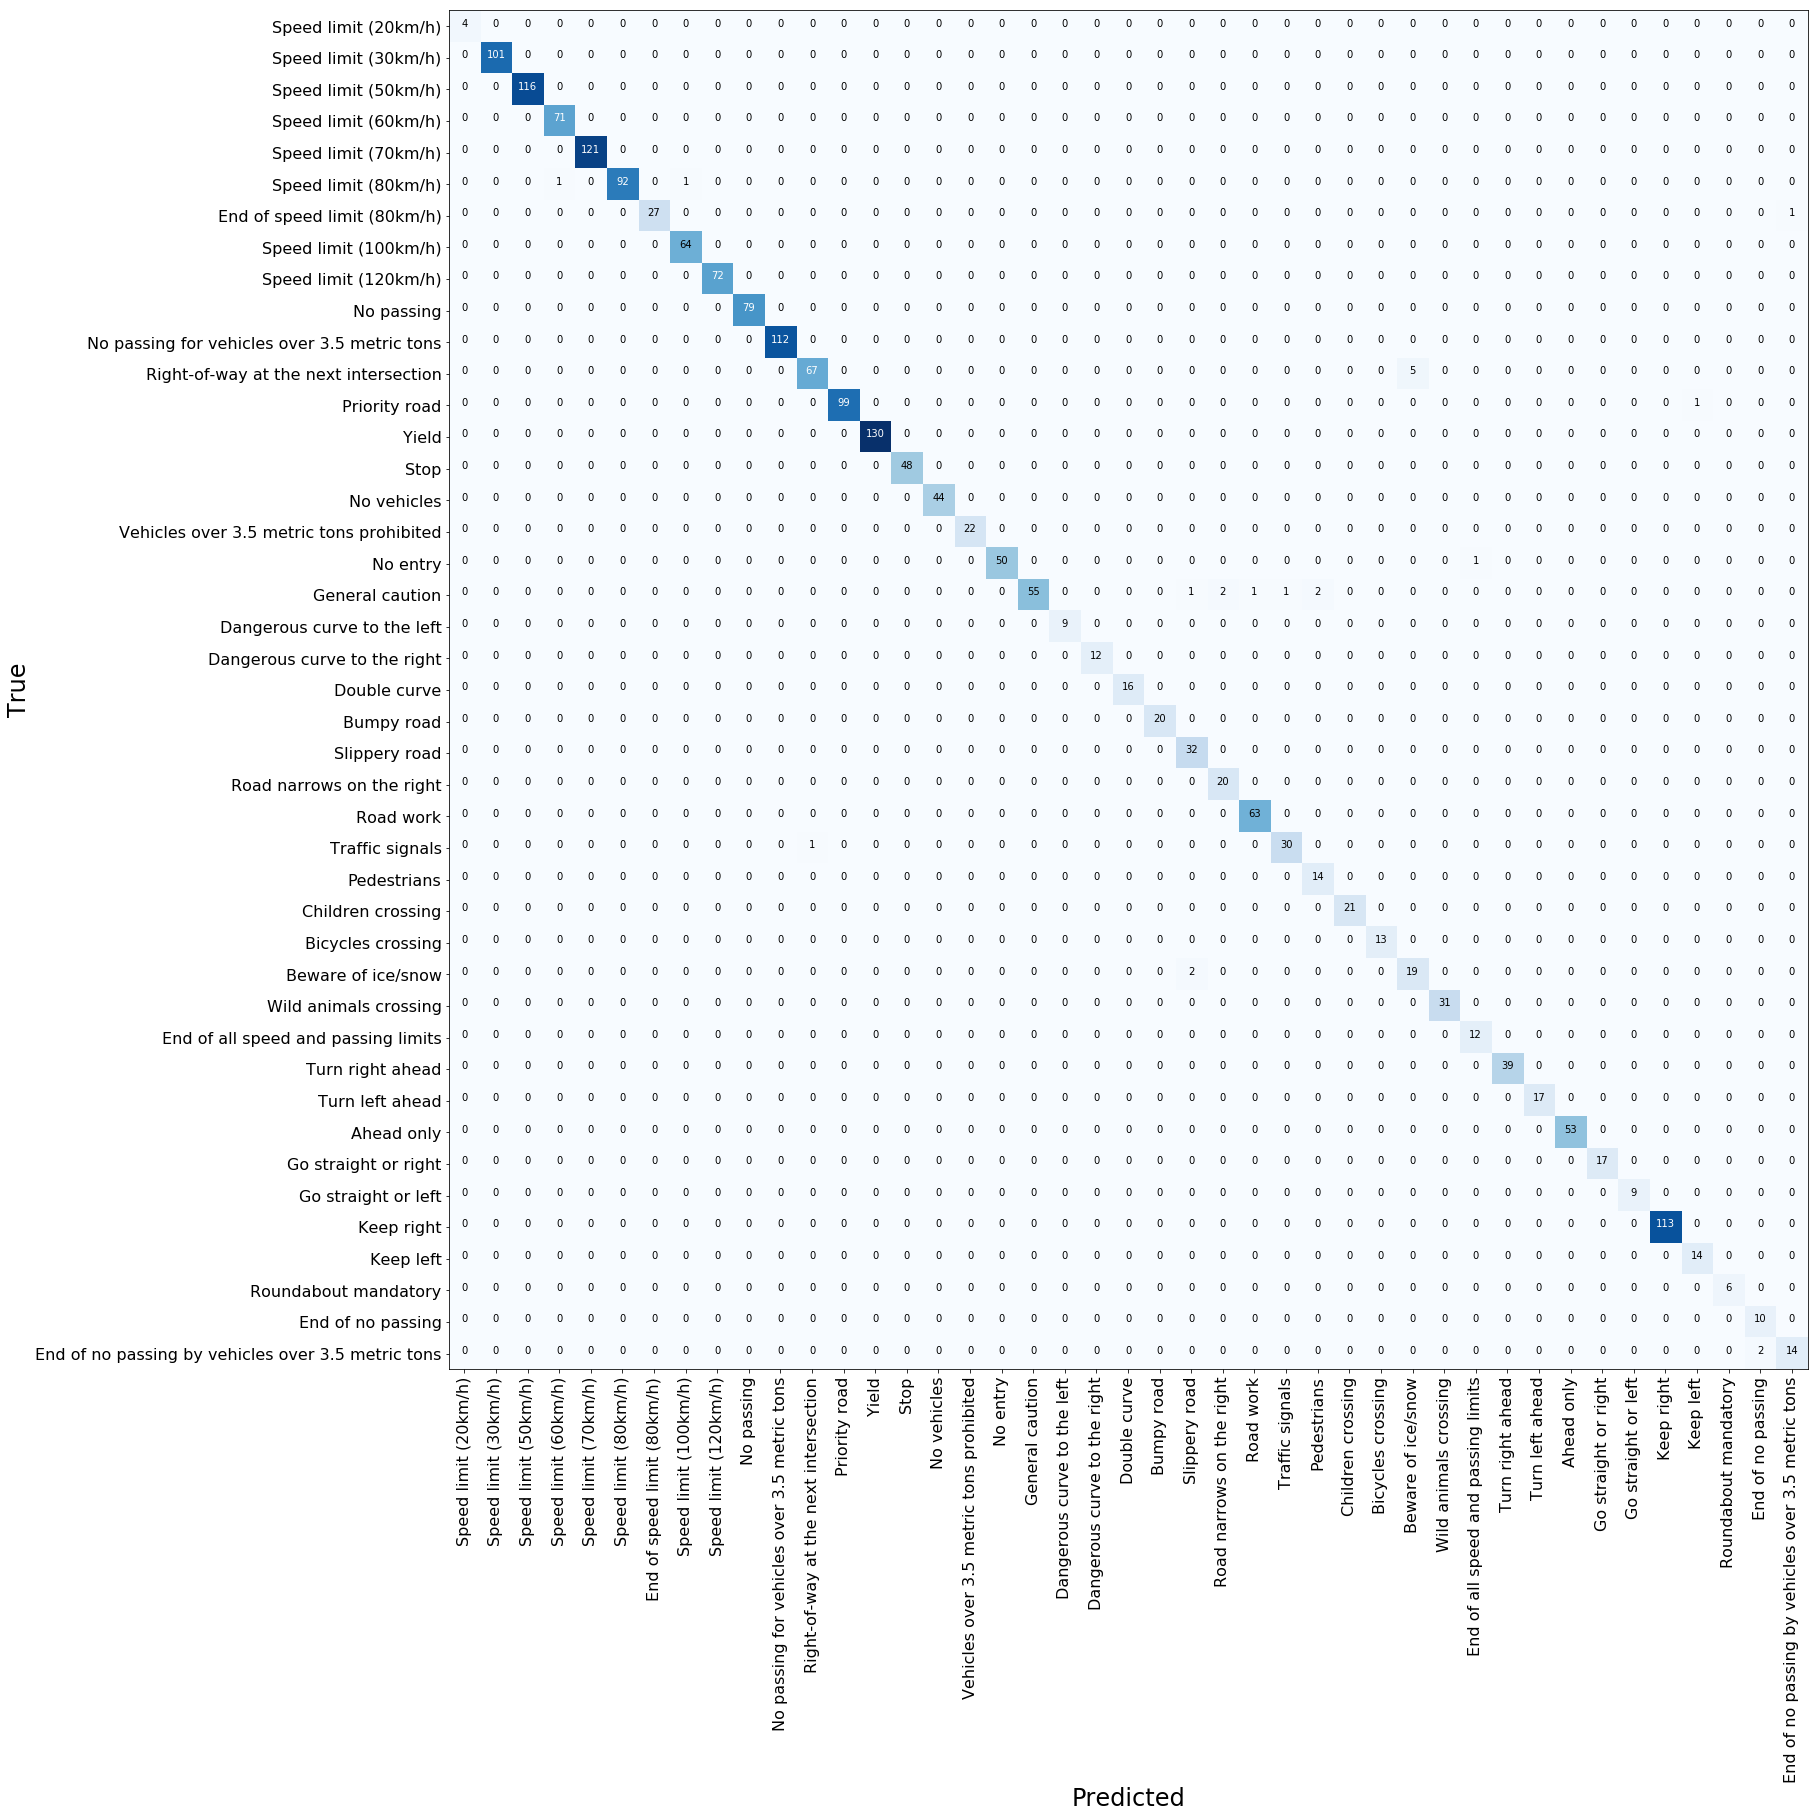

In [38]:
saver=tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,chkpt)
    plot_confusion_matrix(X_test,y_test, 2000, is_tr= False, normalize=False)

### Real World Scenario 

In [13]:
import matplotlib.gridspec as gridspec
from skimage import exposure
from skimage import img_as_ubyte
from skimage import img_as_float
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import argparse
import importlib
import PreProcessing
importlib.reload(PreProcessing)
from PreProcessing import visualize_predictions, image_normalizer, images_show
from tensorflow.python.framework import graph_util

Modules Imported


In [14]:
###### Load Model and Open 
def run_model(X_,image_names):
    saver=tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        total_pred,top5_pred = sess.run([prediction,top5_guesses], feed_dict={x:X_,is_training: False})
    return total_pred, top5_pred

def test_classifier(img_path):

    Images = [image_normalizer(cv2.imread(img_path+name,1)) for name in os.listdir(img_path) if (name.endswith('.png')  or name.endswith('.jpg'))]
    FileNames = [name for name in os.listdir(img_path) if ( name.endswith('.png') or name.endswith('.jpg') )]
    Images_ = img_as_float(Images)
    print("Processed Images")
    images_show(Images_,1,len(FileNames),rand=False)
    total_pred, top5_pred = run_model(Images_,FileNames)
    visualize_predictions(Images_,FileNames,total_pred, top5_pred)


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images
### Predict the Sign Type for Each Image
- **Types of Images**
    - The signs set consist of a few kinds of challenges for the classifier
    - Color changed Turn Left ahead 
    - Multi Sign 
        - No vehicles ahead with a sign that has some writing below but the writing isn't a part of the 43 classes
    - **Elderly Crossing sign** that looks similar to Children crossing but is not in the GTSRB
    - A Slightly Rotated **General Caution** Sign 
    - A **Slippery Road** and **Snow Caution** Sign in the same picture
    - A simple **Children Crossing Sign** etc. 

- The Softmax probabilities are normalized . I.e The logistic regression output from the classifier is activated with a softmax function that ouputs a set of probabilities. These are normalized and plotted (0-1)

- The top 5 guesses are plotted in the neighbouring bar chart and it is for readability and is not normalized. 

Processed Images


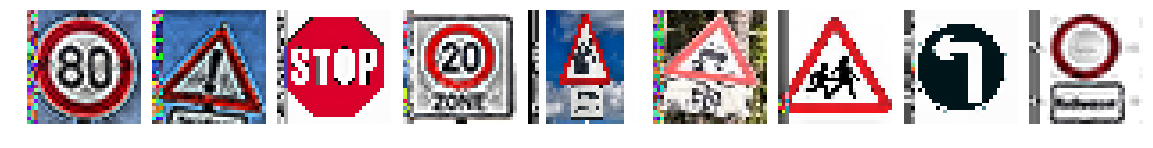

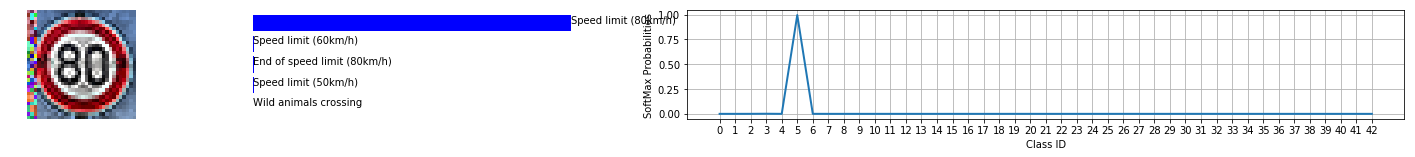

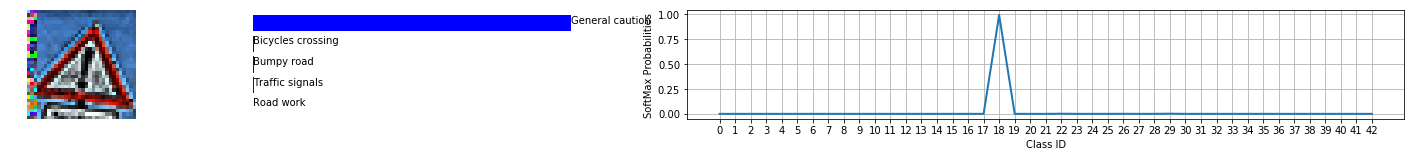

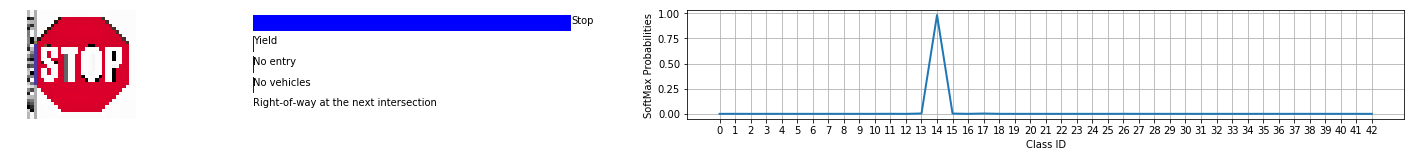

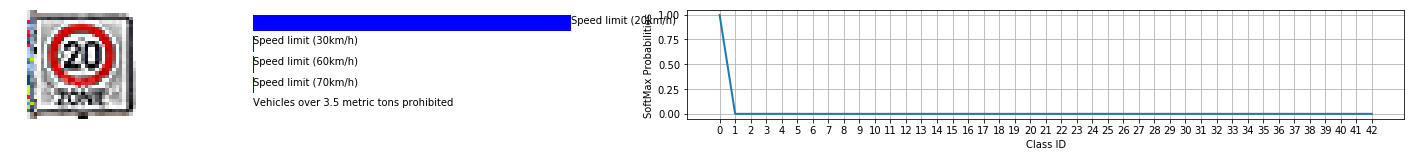

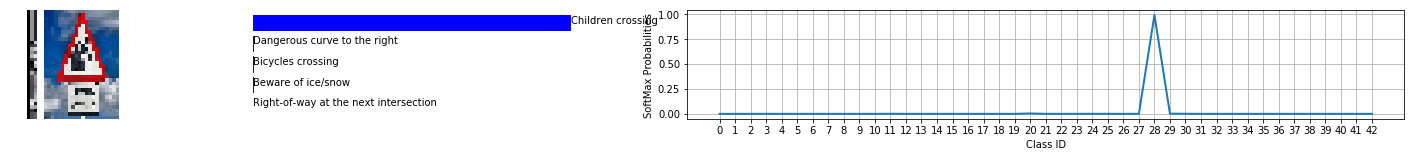

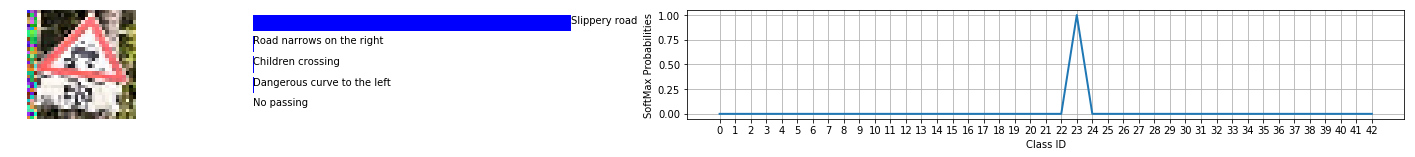

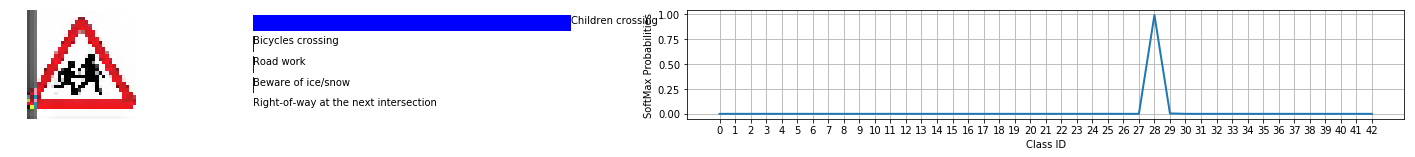

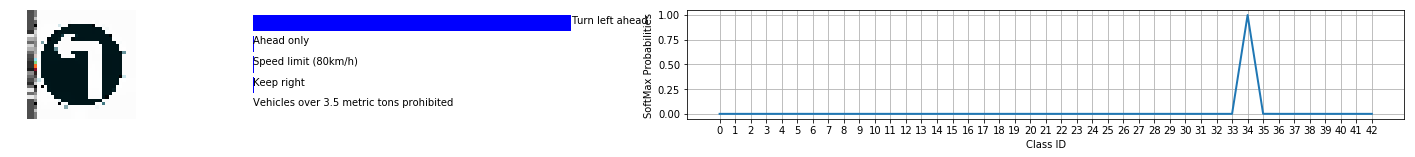

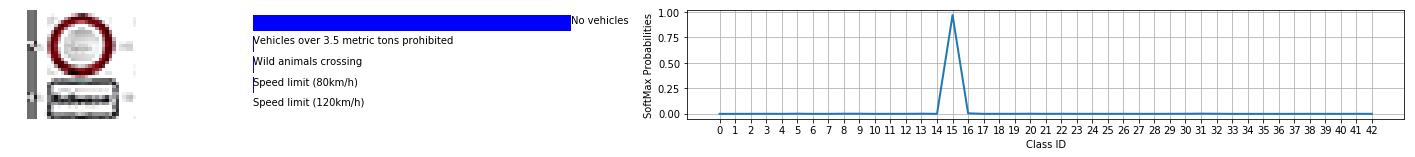

In [15]:
### Define Path of Test Images
image_path ="./Test_images/"
test_classifier(image_path)

### Observations 

### Key Strengths
- Since the challenge to classify image is not so high our model even predicts the images that are not a part of the GTSRB quite intuitively . For Example - Elderly Crossing Looks a lot like children's crossing and the model does a good job predicting it. 
- Color invariance is quite well established , the prediction of turn left ahead works well. 

### Areas of improvement 
- For images that aren't 32x32x3 the resize method's order determines how accurate the prediction is . ( Cubic Spline, BiLinear, etc.) The resize method has the tendency to destroy the aspect ratios in the image that causes deterioration in the performance of the model. 

- The mean centering of images causes a line to appear on the sides of the image while displaying it but does not interfere with the performance of the model itself. 

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [29]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, chkpt, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    saver=tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, chkpt)
        image_reshape=np.expand_dims(image_input,axis=0)
        activation_ = tf.get_default_graph().get_tensor_by_name(tf_activation)
        activation = activation_.eval(session=sess,feed_dict={x : image_reshape,is_training: False })
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(20,15))
        for featuremap in range(featuremaps):
            plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

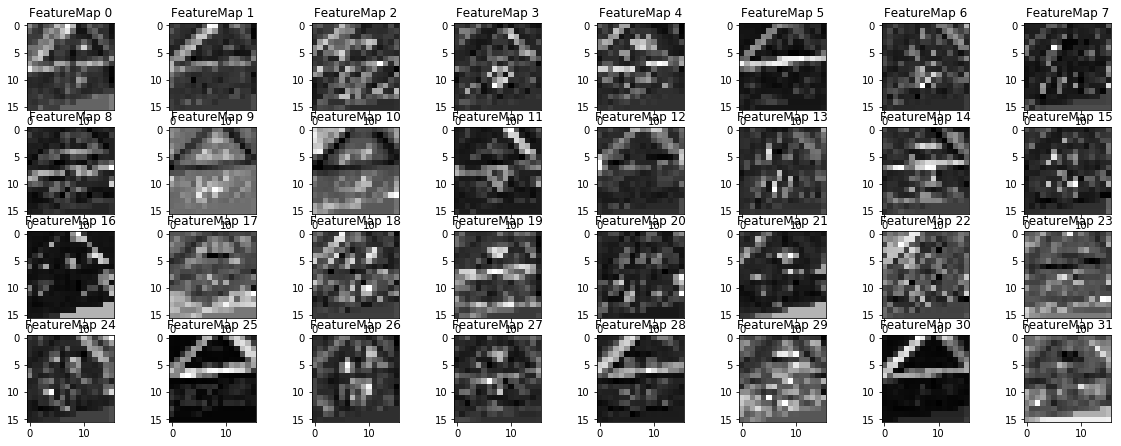

In [30]:
image_path='./Test_images/DoubleSign.jpg'
image=image_normalizer(cv2.imread(image_path))
outputFeatureMap(image,"vgg1pool1:0",chkpt)

### Question 9
Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images

### Answer 
> The visual representation was particularly useful to get information on the way the **spatial transformer** is tuned during the beginning of the training. The output of the Spatial transformer was visualized to see the performance of STN. If it was capable of zooming, rotating the distorted image making it easier for the convolutional network to recognize images. 